# NAA spectra analysis with Neural Networks

This code is written to train a ANN. To run the model you need to have an instalation of Pandas, Numpy and Tensorflow 
in the shell just run the command `pip install tensorflow`.
You need to specify a set of input parameters

- number of neurons NN1
- number of patches
- size of the embedding `num_embeddings = 10`
- number of patches `num_patches = 3` is the number of patches the input data is chunked.
- activation function `activation=gelu`. Other options are `relu` and `selu`


The data is expected to have 2 columns: `channel` and `counts`
In subfolder `/data` we read the experimental parameters associated with each spectrum.

All inputs and outputs are normalized between 0 and 1. 



In [37]:
# Paths where the data is located FILL accordingly 
path_processed = '/Users/armandovieira/Projects/IAEA/4e/'
path_synth = '/Users/armandovieira/Projects/IAEA/4e/data/4e_in_synthetic.csv'
path_origin = '/Users/armandovieira/Projects/IAEA/4e/data/4e_in_data.csv'

num_embeddings = 10
num_patches = 3

# number of files to be read
N_files = 10000

In [6]:
# do the imports
import matplotlib.pyplot as plt
from os import walk
import numpy as np
import pandas as pd
from os import listdir
from os.path import isfile, join
from tensorflow.keras import layers, Model
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
pd.set_option('display.max_rows', 100)

In [38]:
# read the data
def read_data(N_files=None):
    msg = "You need to specify how samples are to be read from the directory"
    assert N_files is not None, msg

    data = {}

#    N_files = 10216
    files = [f for f in listdir(path_processed) if isfile(join(path_processed, f))]
    files = [f for f in files if f.split(".")[-1]=='dat']

    for f in files:
        # read just last column
        temp = pd.read_csv(join(path_processed, f),header=None).iloc[:,-1] 
        data[f] = temp.apply(lambda x: x.split()[-1]).reset_index().iloc[:,-1].astype('float')

    data = pd.DataFrame.from_dict(data).T.astype('float')
    data.index=[x.split(".")[0] for x in files]
    data = data.sort_index(ascending=True).iloc[:N_files]
    print('shape of data is ', data.shape)
    return data

In [39]:
data = read_data(N_files)

shape of data is  (10000, 414)


<AxesSubplot:>

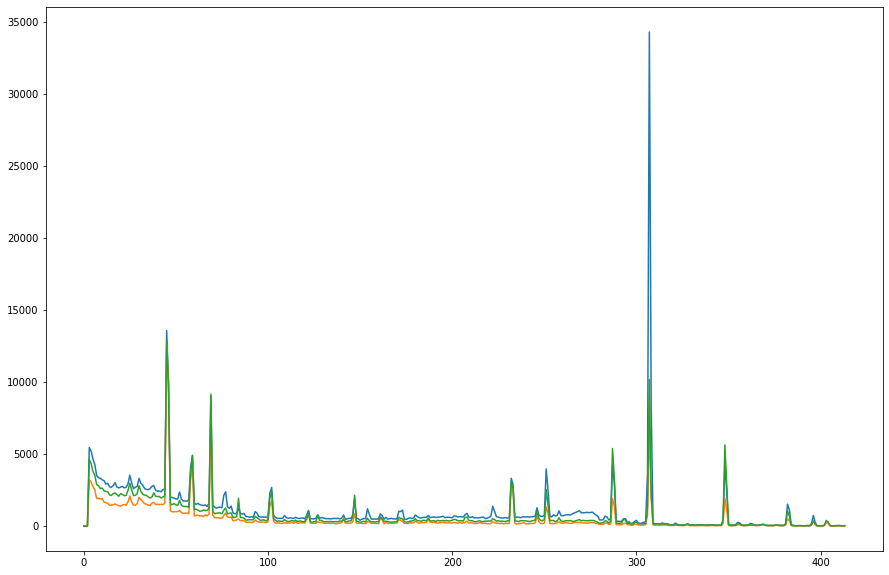

In [55]:
# inspect the data
plt.figure(figsize=(15,10))
data.iloc[1].plot()
data.iloc[10].plot()
data.iloc[100].plot()

In [41]:
# columns to be used from experimental setup
cols_out = ['Se','UNC','LOD']
cols_exp = ['SAMPLE MASS','FILL','CMP']
cols = cols_out + cols_exp

# read experimental setup from real and synthetic data
exp = pd.read_csv(path_origin,sep=";")
expsynt = pd.read_csv(path_synth,sep=";").reset_index().iloc[:N_files]
exptotal = pd.concat([exp[cols],expsynt[cols]],axis=0)

# put Everything in a single datafram
df = pd.concat([exptotal.reset_index(),data.reset_index()],axis=1).drop(columns='index')

# check if there is some NAN in the data
print ('number of NANs ',df.isna().sum().sum())

number of NANs  89424


In [42]:
# setting for a cut in the peak values
peak = 10000
trainx = df.iloc[:,3:].astype('float')
trainx[trainx>peak] = trainx[trainx>peak].apply(lambda x: peak+np.power(x,.2))
# normalize the data
trainx = trainx.apply(lambda x: x/(.0001+x.max()))
trainy = df[cols_out].astype('float').fillna(0)

min_o = trainy.min()
max_o = trainy.max()

trainy = (trainy - trainy.min())/(trainy.max()-trainy.min())
trainx = trainx.astype('float')
trainx.shape

(10216, 417)

In [43]:
# use first 150 points an remaining synthetic for training 
# for test use points 151 to 216
mask = list(np.arange(0,150))+list(np.arange(216,N_files))
mask_test = list(np.arange(151,216))
# trainx_,testx, trainy_,  testy = train_test_split(trainx,trainy,test_size=0.2)
trainx_,testx, trainy_,  testy = trainx.values[mask], trainx.values[mask_test], trainy.values[mask],  trainy.values[mask_test]

Epoch 00349: early stopping
1/1 [==============================] - 0s 159ms/step - loss: 0.0010 - dense_102_loss: 6.6404e-04 - dense_103_loss: 0.0046 - dense_104_loss: 0.0027
[0.0010214957874268293, 0.0006640435894951224, 0.004574472550302744, 0.0026596272364258766]


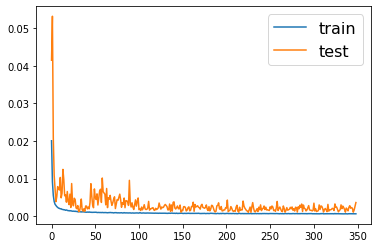

In [66]:
activation = 'gelu'
l=[]

xinput1 = layers.Input(shape=(trainx.shape[1],), name='input_c')

patch_size = int(xinput1.shape[1]//num_patches)

for i in range(num_patches):
    x = layers.Dense(num_embeddings, activation=activation)(xinput1[:,patch_size*i : patch_size*(i+1)])
    s = layers.Dense(2, activation = activation)(xinput1[:,:3])
    x = layers.concatenate([x,s])
    x = layers.Dropout(.01)(x)
    l.append(x)
x = layers.concatenate(l)

x = layers.Dense(20, activation=activation)(xinput1[:,:100])
x = layers.Dropout(.01)(x)
x = layers.Dense(5, activation=activation)(x)
y = [layers.Dense(1)(x) for _ in range(trainy_.shape[1])]

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=120)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)

model = Model(xinput1, y )

#loss_weights for Se, UNC and LODm, respectively 
loss_weights=[1.,.02,.1]
model.compile(loss='mse', optimizer='adam', loss_weights=loss_weights)

# model.summary()
history = model.fit([trainx_], 
                    [trainy_[:,0],trainy_[:,1],trainy_[:,2]],
                    validation_data = ([testx],[testy[:,0],testy[:,1],testy[:,2]]), 
                    epochs=2000, 
                    batch_size=10, 
                    verbose=False,
                    callbacks=[es,mc])

plt.plot(history.history['loss'], label ="train")
plt.plot(history.history['val_loss'], label ="test")
plt.legend(prop={'size': 16})

model = load_model('best_model.h5')
print(model.evaluate([testx]  , [testy[:,0],testy[:,1],testy[:,2]], batch_size=100))

## Load te model and test

In [35]:
model = load_model('best_model.h5')
print(model.evaluate([testx], [testy[:,0],testy[:,1],testy[:,2]], batch_size=100))
print(model.evaluate([trainx_]  , [trainy_[:,0],trainy_[:,1],trainy_[:,2]], batch_size=100))

1/1 [==============================] - 0s 275ms/step - loss: 0.0028 - dense_10_loss: 0.0018 - dense_11_loss: 0.0090 - dense_12_loss: 8.5831e-04
[0.0028203565161675215, 0.0018320019589737058, 0.009025231003761292, 0.0008583131711930037]
10/10 [==============================] - 0s 1ms/step - loss: 6.3749e-04 - dense_10_loss: 3.1420e-04 - dense_11_loss: 0.0020 - dense_12_loss: 0.0013
[0.0006374935619533062, 0.00031419971492141485, 0.0019816653802990913, 0.0012512726243585348]


In [ ]:
# plot the model 
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
)

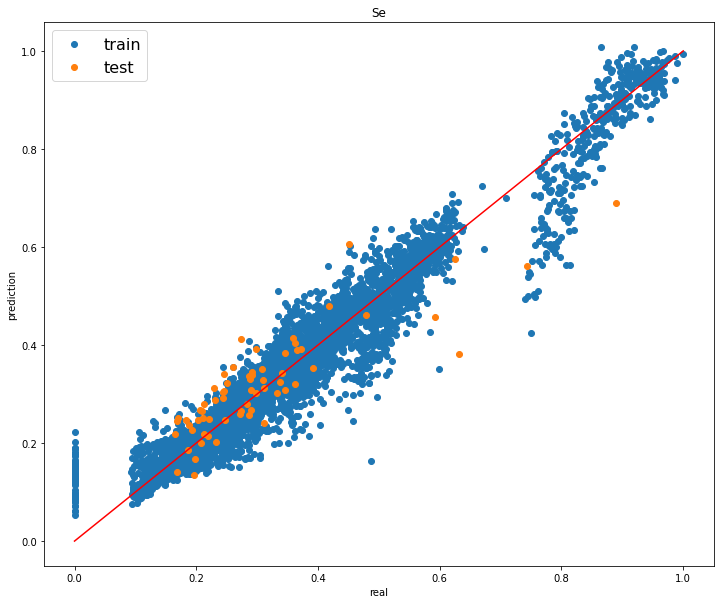

In [63]:
# prediction gives an output array with [Se, UNC, LOC]
plt.figure(figsize=(12,10))
# i = 0, Se, 1 UNC, 2 LOD
i=2
plt.scatter(trainy_[:,i], model.predict(trainx_)[i], label="train")
plt.scatter(testy[:,i], model.predict(testx)[i],     label="test" )
plt.title('Se')
plt.ylabel('prediction')
plt.xlabel('real')
plt.legend(prop={'size': 16})
x = np.linspace(.0,1.,100)
plt.plot(x, x, '-r')

## write the data

In [ ]:
predicted = model.predict(trainx)
results = pd.DataFrame()
results['spectra']= data_nuno.index
# results['Se_real_normalized']= trainy['Se']
results['Se_real']= trainy['Se']*(max_o['Se'] - min_o['Se'])+min_o['Se']
results['Se_predicted']= predicted[0]*(max_o['Se'] - min_o['Se'])+min_o['Se']
results['LOD_real']= trainy['LOD']*(max_o['LOD'] - min_o['LOD'])+min_o['LOD']
results['LOD_predicted']= predicted[1]*(max_o['LOD'] - min_o['LOD'])+min_o['LOD']
results['UNC_real']= trainy['UNC']*(max_o['UNC'] - min_o['UNC'])+min_o['UNC']
results['UNC_predicted']= predicted[2]*(max_o['UNC'] - min_o['UNC'])+min_o['UNC']
results['mask']='train'
results.loc[mask_test,'mask']='test'
results['ratio']  = (results['Se_predicted']/results['Se_real'])

In [ ]:
results.to_csv('results.csv',index=False)